In [141]:
import pandas as pd
import numpy as np
import missingno

# plotting
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sklearn
from sklearn.pipeline import make_pipeline
import sklearn.metrics as metrics
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier # how well does this model improve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

import category_encoders as ce
from xgboost import XGBRegressor
import catboost

sns.set()

SEED = 2

pd.set_option('display.max_columns', 500)

In [142]:
df = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [143]:
df.head()

,id,ship_mode,segment,country,city,state,postal_code,region,category,sub_category,sales,quantity,discount,profit
0,8522,Second Class,Consumer,United States,Everett,Massachusetts,2149,East,Office Supplies,Art,16.280,2,0.00,6.5120
1,7864,Standard Class,Corporate,United States,Los Angeles,California,90036,West,Furniture,Chairs,1684.752,6,0.20,210.5940
2,3522,Standard Class,Consumer,United States,New York City,New York,10035,East,Office Supplies,Storage,242.940,3,0.00,9.7176
3,8694,Standard Class,Consumer,United States,Los Angeles,California,90045,West,Office Supplies,Art,37.170,9,0.00,10.4076
4,2306,Second Class,Home Office,United States,San Francisco,California,94110,West,Furniture,Bookcases,1198.330,10,0.15,70.4900


In [144]:
# look at the dataset
# focus on nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7173 entries, 0 to 7172
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            7173 non-null   int64  
 1   ship_mode     7173 non-null   object 
 2   segment       7173 non-null   object 
 3   country       7173 non-null   object 
 4   city          7173 non-null   object 
 5   state         7173 non-null   object 
 6   postal_code   7173 non-null   int64  
 7   region        7173 non-null   object 
 8   category      7173 non-null   object 
 9   sub_category  7173 non-null   object 
 10  sales         7173 non-null   float64
 11  quantity      7173 non-null   int64  
 12  discount      7173 non-null   float64
 13  profit        7173 non-null   float64
dtypes: float64(3), int64(3), object(8)
memory usage: 784.7+ KB


In [145]:
df.postal_code.nunique()

453

In [146]:
df.describe()

,id,postal_code,sales,quantity,discount,profit
count,7173.000000,7173.000000,7173.000000,7173.000000,7173.000000,7173.000000
mean,4981.020772,57372.577861,233.661716,3.810540,0.132447,36.220375
std,2885.410698,33145.587637,594.146828,2.236801,0.200767,222.338027
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-3839.990400
25%,2483.000000,22980.000000,17.940000,2.000000,0.000000,2.822400
50%,4961.000000,68104.000000,55.980000,3.000000,0.000000,10.179000
75%,7498.000000,90032.000000,215.968000,5.000000,0.200000,33.874400
max,9994.000000,97756.000000,17499.950000,14.000000,0.800000,8399.976000


## data dict

id unique id per row
ship_mode what mode was used to ship the item: 'First Class', 'Same Day', 'Second Class', 'Standard Class'
segment whether the recipient is corporate or consumer
country always United States
city where the item was shipped (a city in the United States)
state where the item was shipped (a state in the United States)
postal_code ZIP Code in the United States
region region in the United States: 'Central', 'East', 'South', 'West'
category type of item: 'Furniture', 'Office Supplies', 'Technology'
sub_category sub-type of item: 'Accessories', 'Appliances', 'Art', 'Binders', 'Bookcases', 'Chairs', 'Copiers', 'Envelopes', 'Fasteners', 'Furnishings', 'Labels', 'Machines', 'Paper', 'Phones', 'Storage', 'Supplies', 'Tables'
sales sales made for the order (USD)
quantity quantity sold of the item
discount discount applied to the order(from 0 to 1)
profit profit made on the order (USD)




In [147]:
# No missing values!

In [148]:
# list of variables with missing values
missing_vals = [var for var in df.columns if df[var].isnull().sum()>1]

for var in missing_vals:
    print(f'var, {np.round(df[var].isnull())} % missing values')

In [149]:
# list of variables with numerical values
num_vars = [var for var in df.columns if df[var].dtypes != 'O']

print("Num of numerical variables: ", len(num_vars))

df[num_vars].head()

Num of numerical variables:  6


,id,postal_code,sales,quantity,discount,profit
0,8522,2149,16.280,2,0.00,6.5120
1,7864,90036,1684.752,6,0.20,210.5940
2,3522,10035,242.940,3,0.00,9.7176
3,8694,90045,37.170,9,0.00,10.4076
4,2306,94110,1198.330,10,0.15,70.4900


In [150]:
# list of variables with numerical values
num_vars = [var for var in df.columns if df[var].dtypes != 'O']

print("Num of numerical variables: ", len(num_vars))

df[num_vars].head()

Num of numerical variables:  6


,id,postal_code,sales,quantity,discount,profit
0,8522,2149,16.280,2,0.00,6.5120
1,7864,90036,1684.752,6,0.20,210.5940
2,3522,10035,242.940,3,0.00,9.7176
3,8694,90045,37.170,9,0.00,10.4076
4,2306,94110,1198.330,10,0.15,70.4900


In [151]:
# picked 20 as an arbitrary cutoff
discrete_vars = [var for var in num_vars if len(df[var].unique())<20]
print(f'Number of discrete variables: ', len(discrete_vars))

df[discrete_vars].head()

Number of discrete variables:  2


,quantity,discount
0,2,0.00
1,6,0.20
2,3,0.00
3,9,0.00
4,10,0.15


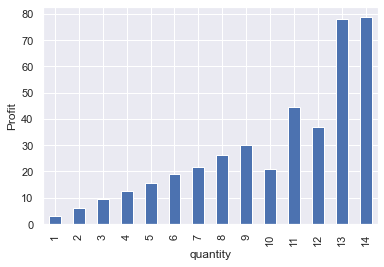

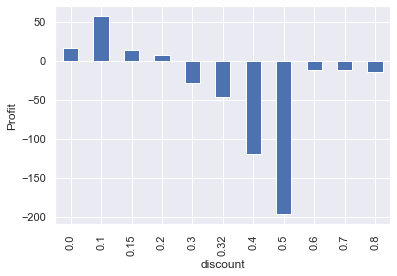

In [152]:
def analyze_discrete_var(df, var):
    """
    Plots discrete variable against target, tip amount.
    """
    df = df.copy()
    
    df.groupby(var)['profit'].median().plot.bar()
    plt.ylabel('Profit')
    plt.xlabel(var)
    plt.show()
    
for var in discrete_vars:
    analyze_discrete_var(df, var)

In [153]:
cont_vars = [var for var in num_vars if var not in discrete_vars]

print(f'Number of continous variables: ', len(cont_vars))

df[cont_vars].head()

Number of continous variables:  4


,id,postal_code,sales,profit
0,8522,2149,16.280,6.5120
1,7864,90036,1684.752,210.5940
2,3522,10035,242.940,9.7176
3,8694,90045,37.170,10.4076
4,2306,94110,1198.330,70.4900


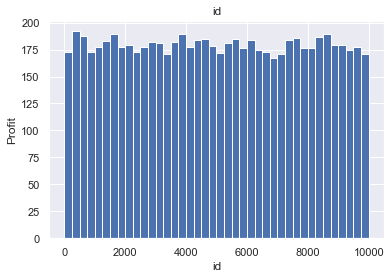

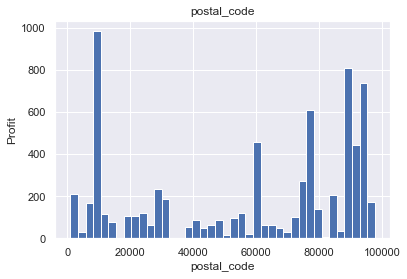

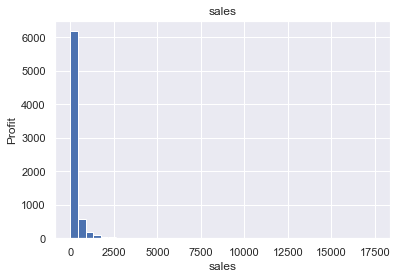

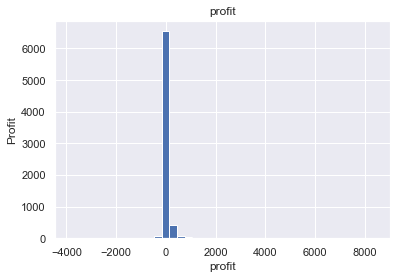

In [154]:
def hist_continuous_var(df, var):
    """
    Plots continuous variable against target, tip amount.
    Histogram shows skew or normal dist. 
    """
    df = df.copy()
    
    df[var].hist(bins=40)
    plt.title(var)
    plt.ylabel('Profit')
    plt.xlabel(var)
    plt.show()
    
for var in cont_vars:
    hist_continuous_var(df, var)

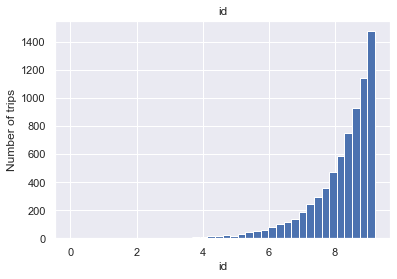

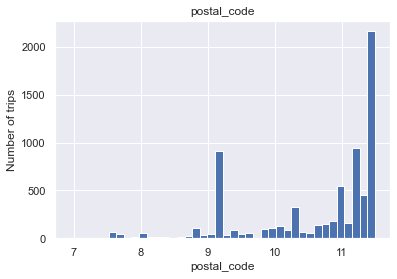

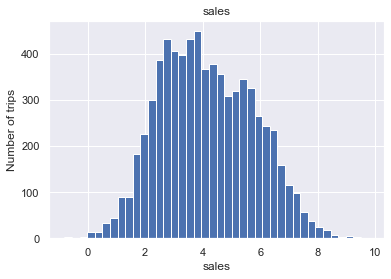

In [155]:
# log transform the cont variables to be more Gaussian
def hist_transformed_continuous_vars(df, var):
    """
    Log transform variables.
    Returns a histogram of log variables. 
    """
    df = df.copy()
    # skip variables with negative values
    if 0 in df[var].unique():
        pass
    else:
        df[var] = np.log(df[var])
        
        df[var].hist(bins=40)
        plt.title(var)
        plt.ylabel('Number of trips')
        plt.xlabel(var)
        plt.show()

for var in cont_vars:
    hist_transformed_continuous_vars(df, var)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


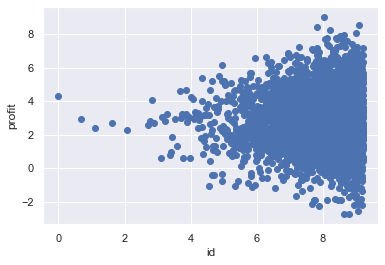

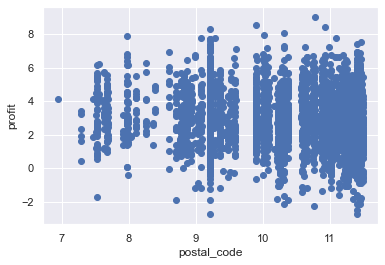

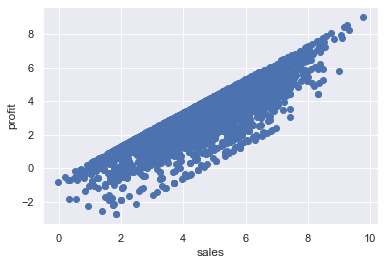

In [156]:
# explore relationship between target, profit, and the transformed variables

def plot_transformed(df, var):
    df = df.copy()
    
    # skip variables with negative values
    if 0 in df[var].unique():
        pass
    else:
        df[var] = np.log(df[var])
        df['profit'] = np.log(df['profit'])
        
        plt.scatter(df[var], df['profit'])      
        plt.ylabel('profit')
        plt.xlabel(var)
        plt.show()

for var in cont_vars:
    if var != 'profit':
        plot_transformed(df, var)

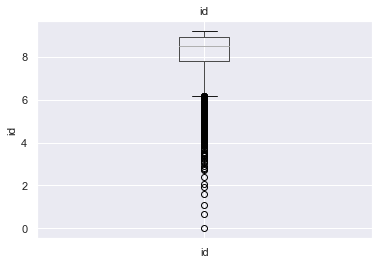

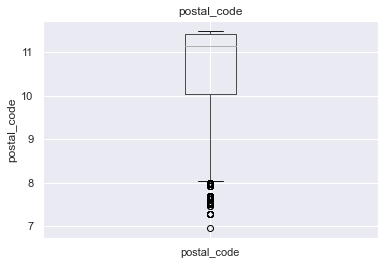

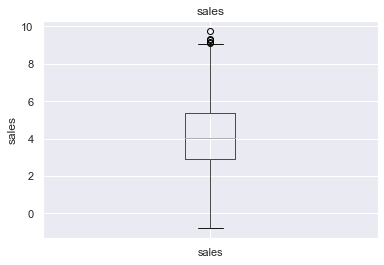

In [157]:
def plot_outliers(df, var):
    df = df.copy()
    
    # skip variables with negative values
    if 0 in df[var].unique():
        pass
    else:
        df[var] = np.log(df[var])
        
        df.boxplot(column=var)
        plt.title(var)
        plt.ylabel(var)
        plt.show()

for var in cont_vars:
    plot_outliers(df, var)

In [158]:
cat_vars = [var for var in df.columns if df[var].dtypes == 'O']
print('Number of categorical variables: ', len(cat_vars))

df[cat_vars].head()

Number of categorical variables:  8


,ship_mode,segment,country,city,state,region,category,sub_category
0,Second Class,Consumer,United States,Everett,Massachusetts,East,Office Supplies,Art
1,Standard Class,Corporate,United States,Los Angeles,California,West,Furniture,Chairs
2,Standard Class,Consumer,United States,New York City,New York,East,Office Supplies,Storage
3,Standard Class,Consumer,United States,Los Angeles,California,West,Office Supplies,Art
4,Second Class,Home Office,United States,San Francisco,California,West,Furniture,Bookcases


## Feature engineering

In [159]:
# Cost per unit
# def unit_cost(df):
#     df = df.assign(unit_cost = ((df['sales'] - df['profit']) / df['quantity']))
#     return df

def dropme(_df):
    return _df.drop(columns=['country'])

def reduce_cardinality(df):
    """
    Need to reduce cardinality of city
    """
    
    # get list of top 10 locations from df
    top10city = df['city'].value_counts()[:9].index
    
    # for cities not in the top 10, replace with OTHER
    df.loc[~df['city'].isin(top10city), 'city'] = 'OTHER'
    
    return df

def clean(df):
    
    df = (df.pipe(dropme)
          .pipe(reduce_cardinality)

         )
    
    return df

In [160]:
df = clean(df)
test = clean(test)
df.head(2)

,id,ship_mode,segment,city,state,postal_code,region,category,sub_category,sales,quantity,discount,profit
0,8522,Second Class,Consumer,OTHER,Massachusetts,2149,East,Office Supplies,Art,16.280,2,0.0,6.512
1,7864,Standard Class,Corporate,Los Angeles,California,90036,West,Furniture,Chairs,1684.752,6,0.2,210.594


In [163]:
# check cardinality of non-numeric features we want to one-hot encode
df.describe(include='O').T.sort_values(by='unique')

,count,unique,top,freq
segment,7173,3,Consumer,3753
category,7173,3,Office Supplies,4353
ship_mode,7173,4,Standard Class,4285
region,7173,4,West,2425
city,7173,10,OTHER,3754
sub_category,7173,17,Binders,1058
state,7173,38,California,2001


In [174]:
cat_vars = [var for var in df.columns if df[var].dtype == 'O']
cat_vars

['ship_mode', 'segment', 'city', 'state', 'region', 'category', 'sub_category']

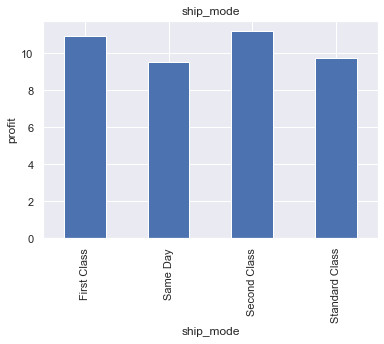

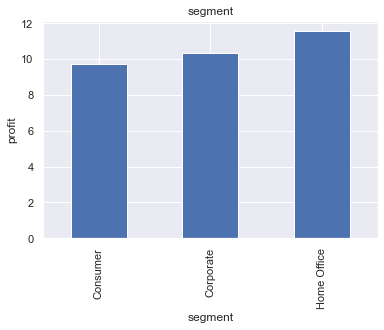

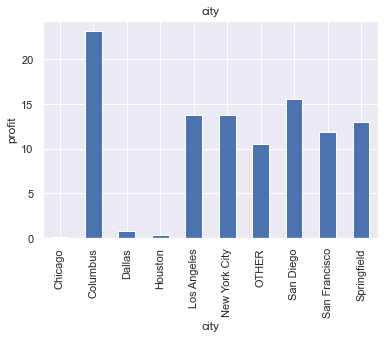

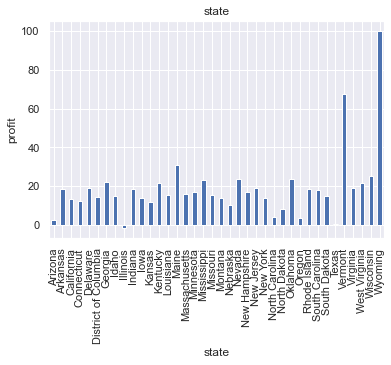

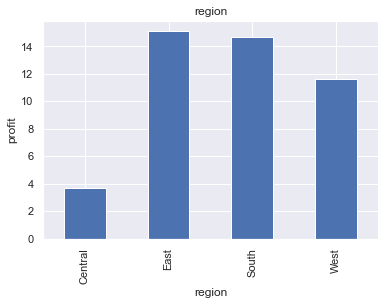

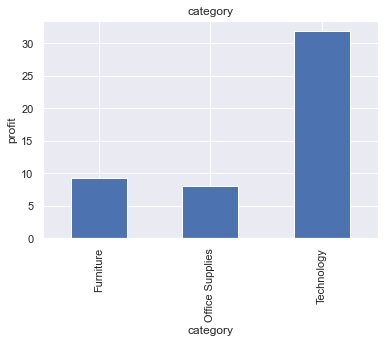

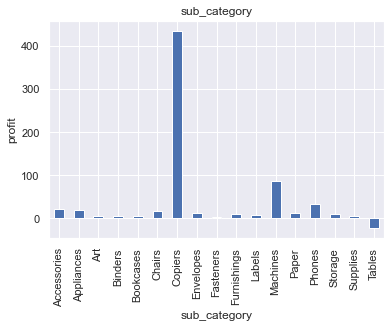

In [175]:
# is there a monotonic relationship between the labels and profit?
def analyse_vars(df, var):
    df = df.copy()
    df.groupby(var)['profit'].median().plot.bar()
    plt.title(var)
    plt.ylabel('profit')
    plt.show()
    
for var in cat_vars:
    analyse_vars(df, var)

In [176]:
y_train = df['profit']
X_train = df.drop(columns='profit')

In [165]:
### Build Model

In [177]:
# Pipeline
xg_pipe = make_pipeline(
            ce.OrdinalEncoder(),
            ce.OneHotEncoder(use_cat_names=True),
            SimpleImputer(), 
            XGBRegressor()
)

# params
params = {
    "xgbregressor__eval_metric":['rmse'],
    "xgbregressor__max_depth": [6, 9, 13],
    "xgbregressor__min_child_weight": [1, 2, 4],
    "xgbregressor__eta": [0.3, 0.4, .09],
    "xgbregressor__strategy": ['mean', 'median']
}

# this implements a “fit” and a “score” method
# not all parameter values are tried out, but a fixed number of parameter settings
# is sampled from the specified distributions. 
# The number of parameter settings that are tried is given by n_iter.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
xg_search=RandomizedSearchCV(
                xg_pipe,
                params,
                n_iter=10,
                scoring='neg_root_mean_squared_error',
                n_jobs=-1,
                cv=5,
                random_state=SEED, verbose=5
)


In [194]:
# estimator: .fit(data, target)
model = xg_search.fit(X_train,
              y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[22:59:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "strategy" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [195]:
# best_params_:
# Parameter setting that gave the best results on the hold out data.

# best_score_: 
# Estimator that was chosen by the search, i.e. estimator which gave highest score (or smallest loss if specified) on the left out data.


print('Best hyperparameters', xg_search.best_params_)
print('Cross-validation best estimator', xg_search.best_score_)

Best hyperparameters {'xgbregressor__strategy': 'median', 'xgbregressor__min_child_weight': 4, 'xgbregressor__max_depth': 6, 'xgbregressor__eval_metric': 'rmse', 'xgbregressor__eta': 0.09}
Cross-validation best estimator -86.39902556738838


In [196]:
# this runs predict() on each feature

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, scoring='neg_root_mean_squared_error', n_iter=2, random_state=42
)

permuter.fit(X_train, y_train)

feature_names = X_train.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None,  # show the permutation importances for all features
    feature_names=feature_names
)

ValueError: could not convert string to float: 'Second Class'

In [180]:
# predict
# use predict_proba for Classification algorithms 
# they usually also offer a way to quantify certainty of a prediction, either using decision_function or predict_proba:
y_pred = xg_search.predict(test)

y_pred

array([  5.9167795, -13.257483 ,  -8.781613 , ...,   5.938255 ,
       -29.267    , -73.56254  ], dtype=float32)

In [181]:
def make_submission(score):
    """Takes prediction array and returns a Kaggle submission df"""
    
    # get the predicted probabilities for the positive label only
    pos_score = score[:]
    
    # put into a df with a column label of target
    pos_score = pd.DataFrame(pos_score, columns=['profit'])
    
    # add original ids from test df 
    submission_df = pd.concat([test.id, pos_score], axis=1)
    
    return submission_df

In [182]:
make_submission(y_pred).to_csv('predictions/attempt2.csv', index=None)